In [1]:
import numpy as np
from astropy.timeseries import LombScargle
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
plt.style.use('seaborn-whitegrid')

In [2]:
data = pd.read_csv("/Users/taigamorioka/Downloads/light_curve_analysis/data_edited/AE Hya_edited.csv")
data.head()

,MJD,Mag,MagErr
0,53761.62688,13.3053,0.06
1,54590.46144,13.1934,0.05
2,54590.45207,13.1924,0.05
3,54998.40708,13.6599,0.06
4,54174.59111,13.1646,0.06


In [3]:
data.shape

(205, 3)

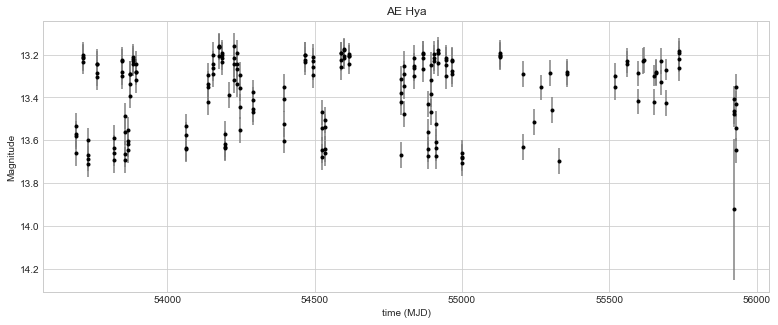

In [4]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.errorbar(data.MJD, data.Mag, data.MagErr,
            fmt='.k', ecolor='gray', capsize=0)
ax.set(xlabel='time (MJD)',
       ylabel='Magnitude',
       title='AE Hya')
ax.invert_yaxis()

In [5]:
#compute span T (# of grids=5*T*f(max); minimum_freq = 1/T)
span=int(max(data.MJD)-min(data.MJD))
span

2237

[4.99317880e-01 9.97300593e-01 9.97211714e-01 4.99295600e-01
 9.99974320e-01 1.00006369e+00 4.99340162e-01 4.99273322e-01
 9.97122852e-01 9.99884965e-01 9.97389486e-01 3.32720230e-01
 3.32710337e-01 3.32730123e-01 1.00015308e+00 4.99362446e-01
 9.97034006e-01 4.99251046e-01 2.49653382e-01 3.32700444e-01
 9.99795626e-01 9.97478396e-01 2.49658952e-01 3.32740018e-01
 3.33027204e-01 4.98628123e-01 2.49647812e-01 4.98605904e-01
 3.33017293e-01 3.60934001e+02]


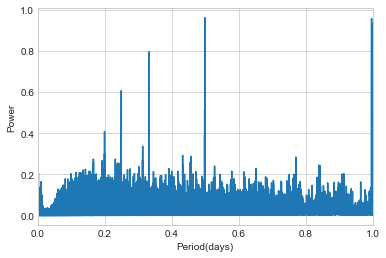

In [6]:
#compute the window function power spectrum
#Zoom up the plot by adjusting the xlim command
frequencyW, powerW = LombScargle(data.MJD, 1, fit_mean=False, center_data=False).autopower(nyquist_factor=span*5, minimum_frequency=span**-1)
plt.plot(1/frequencyW, powerW)
plt.show
plt.xlabel('Period(days)')
plt.ylabel('Power')
plt.xlim(0,1)
print(1/frequencyW[np.argsort(powerW)[-30:][::-1]])

[0.19644519 0.19644864 0.19644174 0.32387016 0.32386079 0.16411778
 0.16411537 0.14097989 0.19645209 0.2444717  0.24463739 0.14097811
 0.24463204 0.32387954 0.32385141 0.24447704 0.14098166 0.16412019
 0.24446636 0.19643829 0.47962768 0.24464274 0.16411297 0.16419003
 0.47964824 0.24462669 0.47960712 0.14097633 0.12351769 0.12351905]


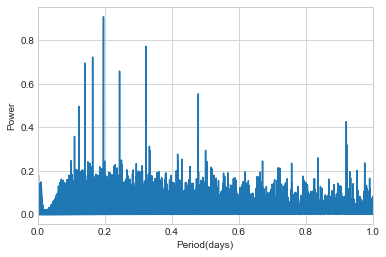

In [7]:
#Compute the LS periodogram and plot the power spectrum
frequency, power = LombScargle(data.MJD, data.Mag, data.MagErr, fit_mean= True).autopower(nyquist_factor= span*5, minimum_frequency = span**-1)
plt.plot(1/frequency, power)
plt.show
plt.xlabel('Period(days)')
plt.ylabel('Power')
plt.xlim(0,1)
print(1/frequency[np.argsort(power)[-30:][::-1]])

In [8]:
# Compute the false alarm probability
# The probability of "a signal with no periodic component would lead to a peak of this magnitude" (VanderPlas, 2018)
# The LS periodogram is chi-square stats and can constract the confidence interval
# The multiterm Fourier method cannot use this feature
ls = LombScargle(data.MJD, data.Mag, data.MagErr)
ls.false_alarm_probability(power[np.argsort(power)[-30:][::-1]])

array([3.20053805e-101, 1.12734465e-079, 1.34764475e-068, 1.25509078e-061,
       3.79645705e-061, 4.72927602e-053, 9.54838063e-051, 5.32740699e-049,
       1.81999455e-046, 6.11189735e-044, 9.21181745e-044, 1.37250300e-043,
       9.63635002e-042, 3.15283816e-041, 9.43203501e-039, 1.43035251e-038,
       2.78377426e-038, 3.20308394e-038, 2.17798563e-035, 1.07876091e-033,
       2.25867319e-032, 3.76024299e-032, 2.67850783e-031, 4.30586794e-029,
       6.08861809e-029, 1.03905167e-028, 6.76884044e-028, 1.07725682e-027,
       4.51484531e-027, 1.83578506e-026])

In [9]:
period_days = 1 / frequency
period_hours = period_days * 24
best_period=0.19644519

phases=np.remainder(data.MJD,best_period)/best_period
phases=np.concatenate((phases,phases+1))
y=np.concatenate((data.Mag,data.Mag))
y_err=np.concatenate((data.MagErr,data.MagErr))

[(0.0, 1.0),
 Text(0.5, 0, 'Period'),
 Text(0, 0.5, 'Power'),
 Text(0.5, 1.0, 'Window Power Spectrum')]

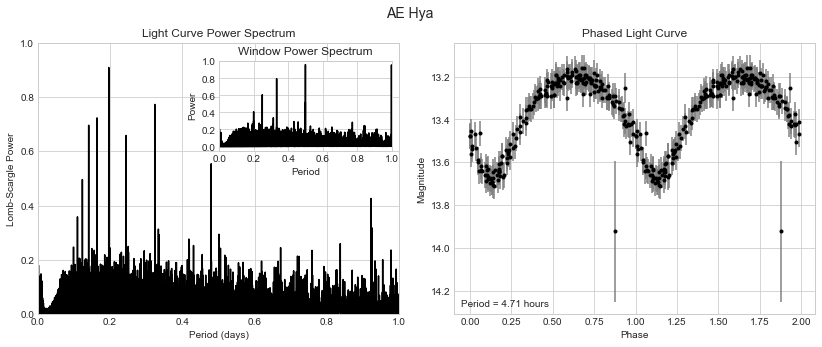

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

fig.suptitle('AE Hya', size=14)
fig.subplots_adjust(hspace=0.35, wspace=0.15, left=0.07, right=0.97)

ax[0].plot(1/frequency, power, '-k', rasterized=True)

ax[0].set(xlim=(0, 1), ylim=(0, 1),
          xlabel='Period (days)',
          ylabel='Lomb-Scargle Power',
          title='Light Curve Power Spectrum')

ax[1].errorbar(phases, y, y_err,
               fmt='.k', ecolor='gray', capsize=0)
ax[1].set(xlabel='Phase',
          ylabel='Magnitude',
          title='Phased Light Curve')
ax[1].invert_yaxis()
ax[1].text(0.02, 0.03, "Period = {0:.2f} hours".format(24 * best_period),
           transform=ax[1].transAxes)

inset = fig.add_axes([0.28, 0.58, 0.2, 0.25])
inset.plot(1/frequencyW, powerW, '-k', rasterized=True)
inset.xaxis.set_major_locator(plt.MultipleLocator(0.2))
inset.yaxis.set_major_locator(plt.MultipleLocator(0.2))
inset.set(xlim=(0, 1),
          xlabel='Period',
          ylabel='Power',
         title="Window Power Spectrum")